<center><h1>Parkinson's Disease Classification with KNN</h1></center>

<subtitle><center>by Group 28 (Michael DeMarco, Philip Zhang, Chris Cai, Yuichi Ito)</center></subtitle>

<img src="praat.png" alt="Praat screenshot" width="400"/>

<center><b>Figure 1</b> A screengrab from Praat, the acoustic analysis software used in collecting the data set</center>

## Abstract

This project aims to classify whether or not a given patient has Parkinson's disease based on various variables derived from their speech sounds. We used a KNN classification algorithm with six predictors to create a model with an accuracy of 80%. We concluded it's accuracy is satisfactory for the scope of DSCI 100, working with the tools we had, but not accurate enough for commercial use. We discussed how this study may be extended to other degenerative diseases. Finally, we elaborated on how one would make such a model usable by the public by providing a website frontend for collecting new data points to test.


## Table of Contents

- Introduction
    - Background
    - Question
    - Data set
- Methods
    - Data wrangling and pre-processing
    - Conducting the Classification Analysis
    - Predictors
    - Visualizing the Results
- Exploration
    - Preliminary exploratory data analysis in R
    - Reading in the data
    - Wrangling
    - Creating the training and testing sets
    - Training set in detail
    - Predictors in detail
- Hypothesis
    - Expected Outcomes
- Results
    - Classification & Visualization
- Discussion
    - Summary
    - Impact
    - Next Steps
- References
    - Works Cited

## 1 Introduction
### Background
Parkinson’s disease (PD) is a degenerative disorder of the central nervous system (CNS) which severely impacts motor control. Parkinson’s has neither a cure nor a known cause. Speech, however, is widely known to play a significant role in the detection of PD. According to Sakar<sup>1</sup> , vocal disorder exists in 90% of patients at an early stage.

[1]  Here's the link to the original [data set](http://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification), and corresponding [paper](https://www.sciencedirect.com/science/article/abs/pii/S1568494618305799?via%3Dihub). Note that the paper used the data set with a similar goal but with very different predictor variables than the ones we select here.

### Question
To what extent can we use elements of speech sounds to predict whether or not a patient has Parkinson’s disease?

### Data set
Our data set is from [UCI’s Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification). This data set contains numerous variables derived from speech sounds gathered by Sakar using the [Praat](http://www.fon.hum.uva.nl/praat/) acoustic analysis software. Each participant in the study was asked to repeat their pronunciations of the /a/ phoneme three times; each entry is thus associated with an ID parameter ranging from 0 to 251.  We chose to focus on the following six predictor parameters:


| Speech Sound Component               | Variable Name in Data Set | Description                                                      |
|------------------------------------------|---------------------------|------------------------------------------------------------------|
| Pitch Period Entropy (PPE)⁠               | PPE                       | measures the impaired control of someone’s pitch                 |
| Detrended Fluctuation Analysis (DFA)⁠     | DFA                       | a measure of the ‘noisiness’ of speech waves                     |
| Recurrence Period Density Entropy (RPDE)⁠ | RPDE                       | repetitiveness of speech waves                                   |
| Jitter                                   | locPctJitter                       | a measure of frequency instability                               |
| Shimmer                                  | locShimmer                       | a measure of amplitude instability                               |
| Fundamental Frequency                    | meanPeriodPulses                       | someone’s pitch (calculated from the inverse of the mean period)⁠ |

<center><b>Figure 2</b> Table describing each of the predictor's used in the original analysis</center>

There’s a lot of complicated mathematics associated with each of these parameters (including Fourier transforms, dense equations, etc.) so the interested reader is encouraged to reference Sakar directly.

## 2 Methods
### Predictors
Many researchers have attempted to use speech signal processing for Parkinson’s disease classification. Based on Sakar and other widely supported literature, the predictors identified above are the most popular speech features used in PD studies and should prove effective. They are also all related to motor control, which is what the early stages of Parkinson’s directly impacts.

### Data wrangling and pre-processing
Each participant’s data (i.e., their pronunciation of /a/) was collected three times; to analyze this data set, each of these three observations was merged by taking the mean of each of our predictor variables in question.

The data was not completely tidy, but the columns that we used were, so the untidy columns were neglected. Next, to be able to conduct classification, our predictor variables were standardized and centered. Each of our variables had a unique distribution; PPE, DFA, and RPDE were on a scale of 0 to 1 and the pitch variable was on an order of magnitude to 10<sup>-3</sup>, for example, so the entire data set was scaled so that we did not have to worry about each variable’s individual distribution.

### Conducting the Classification Analysis
Since our question is a binary classification problem, we used the K-nearest neighbours classification algorithm (KNN). We optimized our choice of k using cross-validation on our training set, and then used the optimal choice of k to create our final model. We then determined its accuracy using the test set.

### Visualizing the Results
To visualize the effectiveness of our KNN model, we were not able to draw a scatter plot directly, as we worked with more than 2-dimensions. We had a line plot showing the trend of increasing values of k on the accuracy of our model for many folds to assist in determining which k we should use for our final model. Then, we created a bar plot to show the number of correct predictions, false positives, and false negatives.

<img src="example-knn.png" alt="Example KNN plot" width="400"/>

<center><b>Figure 3</b> An example knn visualization with only two predictors. </center>

## 3 Exploration
### Exploratory data analysis

We conducted a preliminary exploration of the data, to getter a better sense of what we were working with.

In [1]:
# Reinstall packages (if needed)
# install.packages("tidyverse")
# install.packages("caret")
# install.packages("repr")
# install.packages("GGally")
# install.packages("formula.tools")

# Fix for strange error message
# install.packages("e1071")

In [2]:
# Load in the necessary libraries
library(caret)
library(repr)
library(GGally)
library(tidyverse)
library(formula.tools)

Loading required package: lattice

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.0     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()



In [3]:
# Make all of the following results reproducible, use this value across the analysis
set.seed(28)

### Reading in the data
To begin, we read in the data from the UCI repository. We did not read it directly from UCI's URL, as it contained a zip, and trying to deal with that in R is tedious. Rather, we uploaded the file to Google Drive and we accessed it from there.

In [4]:
# Reads the dataset from the web into R; the Drive URL is self-made
pd_data <- read_csv("https://drive.google.com/uc?export=download&id=1p9JuoTRM_-t56x7gptZU2TRNue8IHFHc", skip = 1)

#narrows down the dataset to the variables that we will use
baseline_data <- pd_data %>%
                select(id:meanHarmToNoiseHarmonicity, class)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



In [5]:
head(baseline_data)

id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0.85247,0.71826,0.57227,240,239,0.008063530,0.000086800,0.00218,...,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,1
0,1,0.76686,0.69481,0.53966,234,233,0.008258256,0.000073100,0.00195,...,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,1
0,1,0.85083,0.67604,0.58982,232,231,0.008339590,0.000060400,0.00176,...,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,1
1,0,0.41121,0.79672,0.59257,178,177,0.010857733,0.000182739,0.00419,...,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,1
1,0,0.32790,0.79782,0.53028,236,235,0.008161574,0.002668863,0.00535,...,0.05610,0.497,0.02909,0.03327,0.05278,0.08728,0.975754,0.027139,19.557,1
1,0,0.50780,0.78744,0.65451,226,221,0.007631204,0.002696381,0.00783,...,0.07752,0.678,0.03805,0.04767,0.06451,0.11415,0.906720,0.137088,14.676,1


<center><b>Figure 4</b> A slice of the basline data loaded from the UCI repository</center>

### Wrangling

As was mentioned in the methods section, each participant was represented three times (e.g., see three rows with `id == 0` above). We merged these by taking the mean of each of the predictor columns, after grouping by `id`.

In [6]:
# Averages the values of each subject's three trials so that each subject is represented by one row

project_data <- baseline_data %>%
                group_by(id) %>%
                summarize(PPE = mean(PPE),
                     DFA = mean(DFA),
                     RPDE = mean(RPDE),
                     meanPeriodPulses = mean(meanPeriodPulses),
                     locPctJitter = mean(locPctJitter),
                     locShimmer = mean(locShimmer),
                     # meanAutoCorrHarmonicity = mean(meanAutoCorrHarmonicity),--legacy from project proposal
                     class = mean(class)) %>%
                     mutate(class = as.factor(class)) %>%
                     mutate(has_pd = (class == 1))
head(project_data)

id,PPE,DFA,RPDE,meanPeriodPulses,locPctJitter,locShimmer,class,has_pd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
0,0.8233867,0.6963700,0.5672500,0.008220459,0.0019633333,0.07100333,1,TRUE
1,0.4156367,0.7939933,0.5924533,0.008883504,0.0057900000,0.06271000,1,TRUE
2,0.8019733,0.6199667,0.5205633,0.006040677,0.0022166667,0.04095333,1,TRUE
3,0.8287067,0.6260967,0.5371833,0.003913008,0.0007566667,0.04946667,1,TRUE
4,0.8312867,0.7793967,0.7267167,0.005621587,0.0035933333,0.15919333,1,TRUE
5,0.8225200,0.6220833,0.3576600,0.006814760,0.0009400000,0.03258333,1,TRUE


<center><b>Figure 5</b> A table containing the tidied data and only relevant columns remaining</center>

### Creating the training and testing sets
Below we created the training and test sets using `createDataPartition()` from the `caret` package.

In [7]:
# Determines which percentage of rows will be used in the training set and testing set (75%/25% split)
set.seed(28)

training_rows <- project_data %>%
                select(has_pd) %>%
                unlist() %>%
                createDataPartition(p = 0.75, list = FALSE)

# Splits the dataset into a training set and testing set
training_set <- project_data %>% slice(training_rows)
testing_set <- project_data %>% slice(-training_rows)

head(training_set)

id,PPE,DFA,RPDE,meanPeriodPulses,locPctJitter,locShimmer,class,has_pd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
1,0.4156367,0.7939933,0.5924533,0.008883504,0.005790000,0.06271000,1,TRUE
2,0.8019733,0.6199667,0.5205633,0.006040677,0.002216667,0.04095333,1,TRUE
4,0.8312867,0.7793967,0.7267167,0.005621587,0.003593333,0.15919333,1,TRUE
5,0.8225200,0.6220833,0.3576600,0.006814760,0.000940000,0.03258333,1,TRUE
6,0.8000333,0.6672833,0.3915767,0.006713578,0.001276667,0.05228667,1,TRUE
7,0.5291933,0.7748567,0.7126800,0.008029424,0.007440000,0.13953250,1,TRUE


<center><b>Figure 6</b> A slice of our training set data, after splitting our data into two separate sets </center>

As mentioned in the data wrangling section of "Methods," we eventually scaled our data. Scaling and other pre-processing was done in the analysis section.

### Testing set in detail

Here we looked at the testing set in more detail, exploring the balance and spread of our selected columns.

In [8]:
# Reports the number of counts per class
class_counts <- training_set %>%
                    group_by(has_pd) %>%
                    summarize(n = n())
class_counts

has_pd,n
<lgl>,<int>
FALSE,48
TRUE,141


<center><b>Figure 7</b> A table displaying the balance in our training set </center>

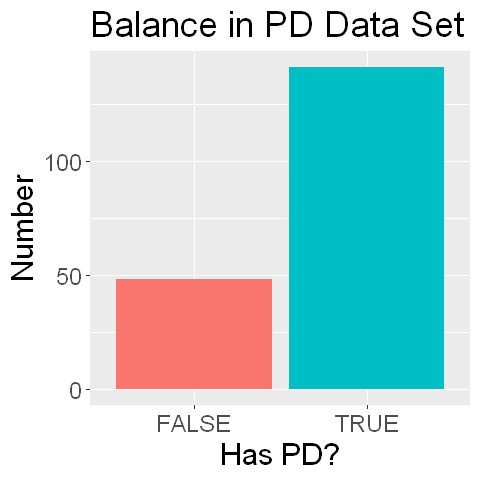

In [9]:
options(repr.plot.width=4,repr.plot.height=4)

class_counts_plot <- ggplot(class_counts, aes(x = has_pd, y = n, fill = has_pd)) + 
                   geom_bar(stat="identity") +
                   labs(x = 'Has PD?', y = 'Number', fill = "Has PD") +
                   ggtitle("Balance in PD Data Set") +
                   theme(text = element_text(size = 18), legend.position = "none")
class_counts_plot

<center><b>Figure 8</b> Visualizing the balance in our training set using a bar chart </center>

We had many more—almost three times as many—patients with PD than without in this data set. Therefore, we could conclude our training set was somewhat imbalanced (in fact, it was the same imbalance as the original data set thanks to `createDataPartition()` handling stratification for us); however, it was not severe enough to warrant use of `upScale()`. This limitation is further discussed at the end of our analysis.

In [10]:
# Reports the means, maxes, and mins of each predictor variable used
predictor_max <- training_set %>%
                        select(PPE:locShimmer) %>%
                        map_df(~ max(., na.rm  = TRUE))
predictor_min <- training_set %>%
                        select(PPE:locShimmer) %>%
                        map_df(~ min(., na.rm  = TRUE))
predictor_mean <- training_set %>%
                        select(PPE:locShimmer) %>%
                        map_df(~ mean(., na.rm  = TRUE))

stats_merged <- rbind(predictor_max, predictor_min, predictor_mean)

stat <- c('max','mean','min')

stats_w_names <- data.frame(stat, stats_merged)

predictor_stats <- gather(stats_w_names,
                              key = variable,
                              value = value,
                              PPE:locShimmer)
predictor_stats

stat,variable,value
<chr>,<chr>,<dbl>
max,PPE,0.851843333
mean,PPE,0.328186667
min,PPE,0.741362857
max,DFA,0.851113333
mean,DFA,0.555966667
min,DFA,0.698315467
max,RPDE,0.826476667
mean,RPDE,0.200946667
min,RPDE,0.492768607


<center><b>Figure 9</b> A table containing the mean, max, and min of each of our predictor variables </center>

### Predictors in detail

In [11]:
# Visualizes and compares the distributions of each of the predictor variables
plot_pairs <- training_set %>% 
              select(PPE:locShimmer) %>% 
              ggpairs(title = "PD speech predictor variable correlations")
# plot_pairs
plot_pairs_by_class <- training_set %>%
                       ggpairs(.,
                               legend = 9,
                               columns = 2:8, 
                               mapping = ggplot2::aes(colour=has_pd), 
                               lower = list(continuous = wrap("smooth", alpha = 0.3, size=0.1)),
                               title = "PD speech predictor variable correlations by class") +
                       theme(legend.position = "bottom")
# plot_pairs_by_class

The following two plots were created using the `GGPairs` library. The first, without color, strictly provides detail about the distribution and correlation between each pair created from our six predictor variables. Three of our predictors, DFA, RPDE, and meanPeriodPulses take on a much wider range of values than PPE, jitter, and shimmer. Many of our variables exhibit somewhat positive correlations on the scatterplot, though some have an entirely fuzzy distribution. For example, compare the plots in the PPE column to those in the RPDE column. This likely comes as a result of the spread of the predictors.

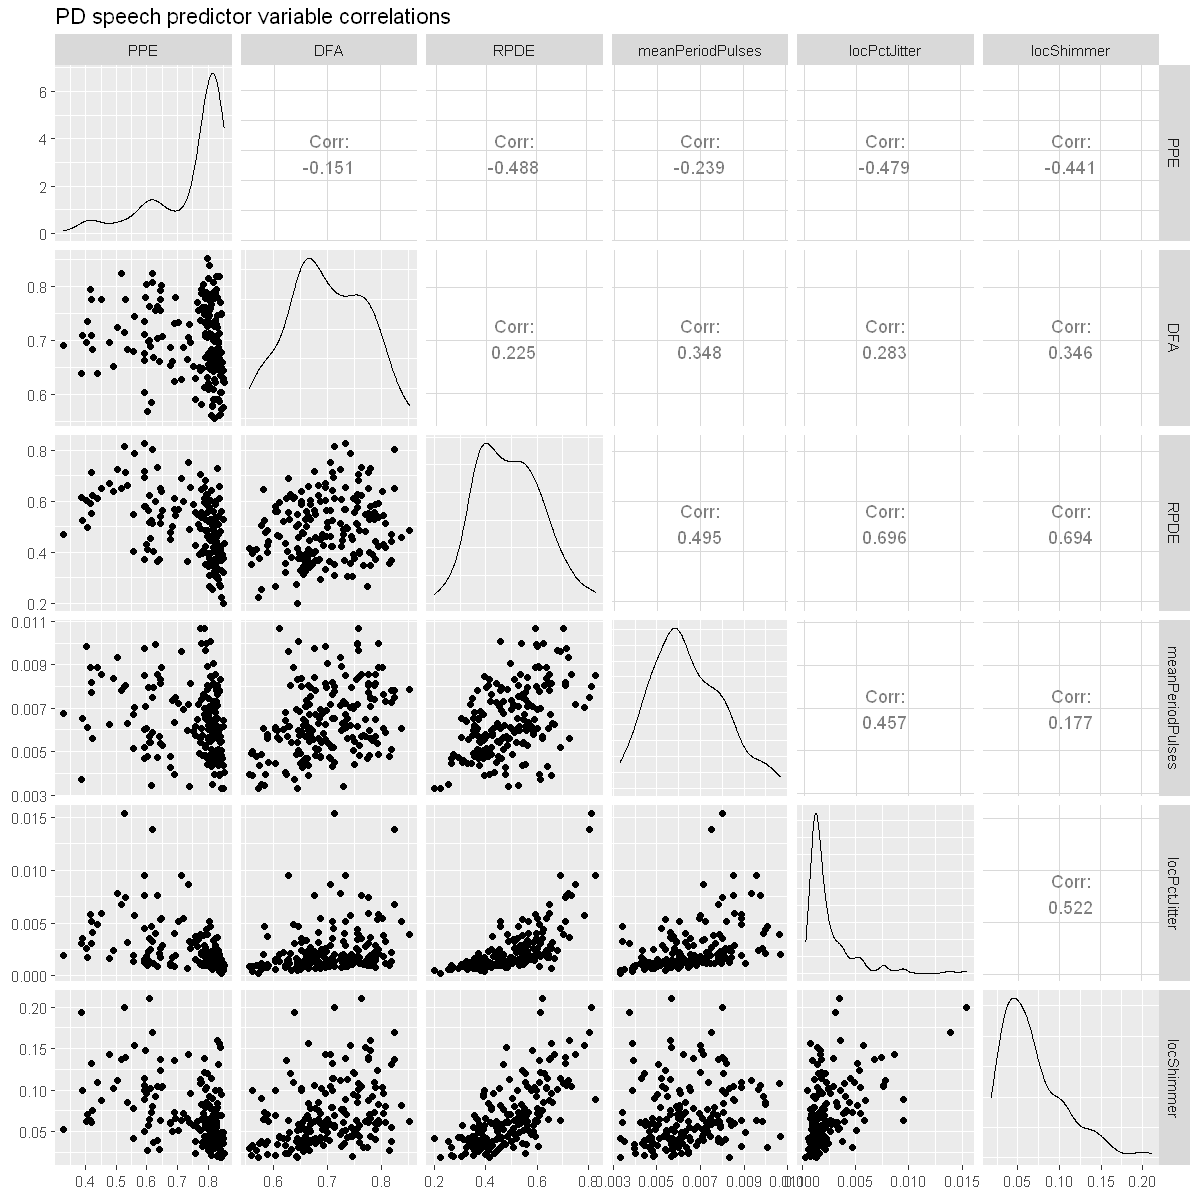

In [12]:
options(repr.plot.width=10,repr.plot.height=10, repr.plot.pointsize=20)

plot_pairs

<center><b>Figure 10</b> A pairwise visualization exploring the relationships between our predictor variables </center>

With this understanding, we used a second plot, grouped and colored by `has_pd`, to assist in anticipating what the impact of these predictors would be. We noted that for every individual distribution, there is a marked difference between the red and blue groupings, which boded well for our analysis. On average, the healthy patients (i.e., `has_pd == FALSE`) fell on the lower end of the spectrum for our predictors, apart from PPE, where healthy patients exhibited higher values on average. Though we weren’t able to visualize our final model directly (as it was in six dimensions), we predicted from these plots that the new patients which fell on the "lower end" for most of these variables would be healthy. This also made intuitive sense; Parkinson’s is a degenerative disease for the muscles, so unhealthy patients would likely experience more rapid change in various speech variables due to tremors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



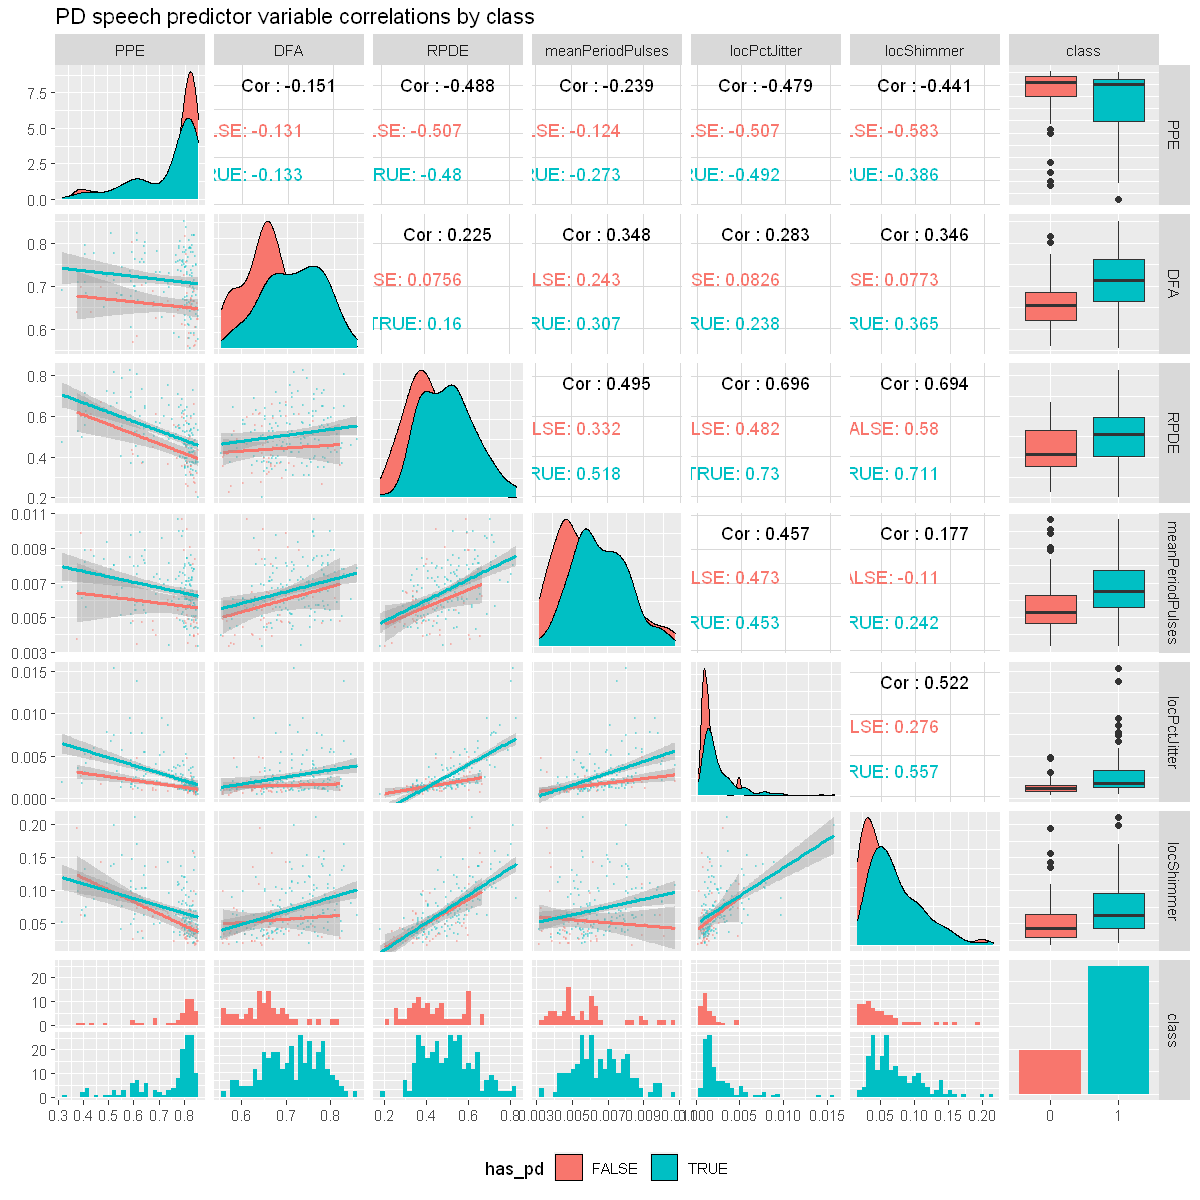

In [13]:
options(repr.plot.width=10,repr.plot.height=10, repr.plot.pointsize=20)

plot_pairs_by_class

<center><b>Figure 11</b> Another visualization of the relationship between our predictors, now with their class distributions considered </center>

## 4 Hypothesis

### Expected Outcomes
From our analysis, we expected to find that the six variables of speech we identified could form an effective model for determining whether or not a patient has Parkinson’s. We anticipated our findings would allow us to make reasonable predictions of whether or not a new patient has PD given their speech data.

## 5 Analysis
### Classification & Visualization

#### Using all predictors from proposal
Below is our first attempt at constructing a classification model using all predictors from the proposal.

In [14]:
# Scale the data set (pre-processing)
scale_transformer <- preProcess(training_set, method = c("center", "scale")) 
training_set <- predict(scale_transformer, training_set)
testing_set <- predict(scale_transformer, testing_set)
# head(training_set)
# head(testing_set)

In [15]:
X_train <- training_set %>% 
  select(-class, -has_pd) %>% 
  data.frame()
X_test <- testing_set %>% 
  select(-class, -has_pd) %>% 
  data.frame()
Y_train <- training_set %>% 
  select(class) %>% 
  unlist()
Y_test <- testing_set %>% 
  select(class) %>% 
  unlist()
# head(X_train)
# head(Y_train)

In [16]:
train_control <- trainControl(method="cv", number = 10)
k <- data.frame(k = seq(from = 1, to = 51, by = 2))
knn_model_cv_10fold <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
# knn_model_cv_10fold

In [17]:
accuracies <- knn_model_cv_10fold$results
head(accuracies)

,k,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.7463450,0.2688708,0.08445645,0.2466141
2,3,0.7293860,0.1696650,0.05158538,0.1909104
3,5,0.7568713,0.2318115,0.05562412,0.2155612
4,7,0.7513158,0.1898169,0.07440820,0.2437319
5,9,0.7621345,0.1817654,0.06555641,0.2504581
6,11,0.7404971,0.1091229,0.04697234,0.2144579


<center><b>Figure 12 </b> A table containing the accuracy values for our first few values of k </center>

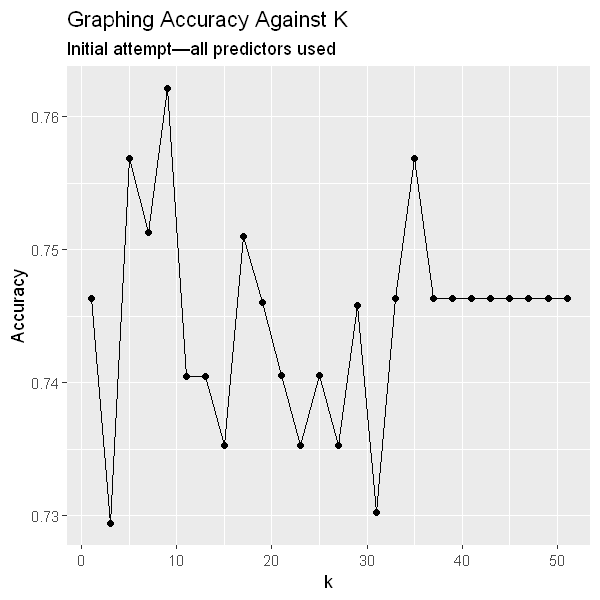

In [18]:
options(repr.plot.height = 5, repr.plot.width = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line() + 
  ggtitle("Graphing Accuracy Against K") +
  labs(subtitle = "Initial attempt—all predictors used")
accuracy_vs_k

<center><b>Figure 13 </b> A plot of accuracies of various k-values for a 10-fold cross-validation </center>

In [19]:
k <- accuracies %>%
    arrange(desc(Accuracy)) %>%
    head(n = 1) %>%
    select(k)
k

,k
,<dbl>
1,9


<center><b>Figure 14 </b> A table containing the optimal choice of k </center>

It looks like a choice of 5 here yields the high accuracy value. After approximately a k value of 40, our accuracy plateaus at just above 0.75. We will now retrain our model using this choice of k.

In [20]:
k = data.frame(k = 5)
model_knn <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)
# model_knn

In [21]:
Y_test_predicted <- predict(object = model_knn, X_test)
# head(Y_test_predicted)

In [22]:
model_quality <- confusionMatrix(data = Y_test_predicted, reference = Y_test)
model_quality

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  5  2
         1 11 45
                                         
               Accuracy : 0.7937         
                 95% CI : (0.673, 0.8853)
    No Information Rate : 0.746          
    P-Value [Acc > NIR] : 0.2383         
                                         
                  Kappa : 0.3314         
                                         
 Mcnemar's Test P-Value : 0.0265         
                                         
            Sensitivity : 0.31250        
            Specificity : 0.95745        
         Pos Pred Value : 0.71429        
         Neg Pred Value : 0.80357        
             Prevalence : 0.25397        
         Detection Rate : 0.07937        
   Detection Prevalence : 0.11111        
      Balanced Accuracy : 0.63497        
                                         
       'Positive' Class : 0              
                                         

<center><b>Figure 15 </b> Our final model statistics for our data set with all predictors </center>

Our final model had an accuracy of 79.4%, which is pretty good! Give our model is in six dimensions, there is no simple visualization for it. However, we can visualize whether or not our model had more false positives or false negatives, and which it was better are predicting: sick or healthy. The confusion matrix gives us all of these values in a 2x2 grid.

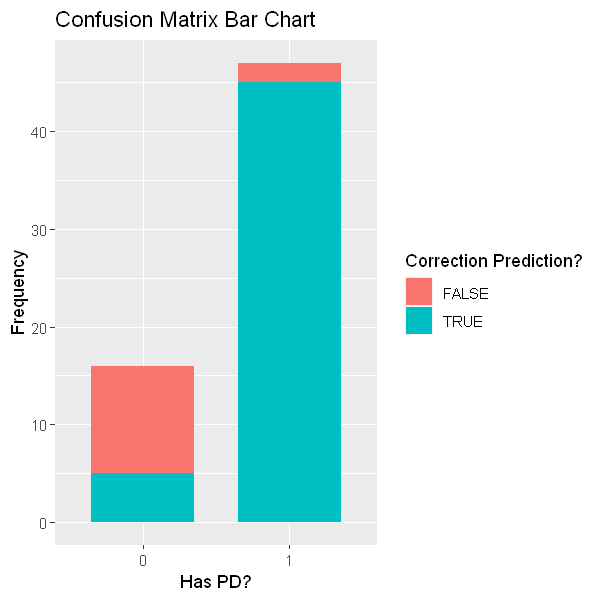

In [23]:
# Create a dataset
matrix_table <- as.data.frame(model_quality$table) %>%
    mutate(isCorrect = (Prediction == Reference))
# matrix_table

matrix_plot <- ggplot(matrix_table, aes(fill = isCorrect, x = Reference, y = Freq)) +
  geom_bar(position="stack", stat="identity", width = 0.7) + 
  labs(title = "Confusion Matrix Bar Chart", y = "Frequency", x = "Has PD?") +
  scale_fill_discrete(name="Correction Prediction?")
matrix_plot

<center><b>Figure 16 </b> Visualizing our confusion matrix table; note that on the bottom if 'Has PD?' is 1, this means the patient does have Parkinson's. </center>

We noted from the above bar chart that our model was fairly accurate at predicting whether or not a patient *did* have Parkinson's, but were very inaccurate when working with *healthy* patients. This was likely a result of our imbalanced training set, though we did still end up with an 80% accuracy.

## 6 Discussion
### Summary
### Impact

Being able to predict Parkinson’s accurately has significant impact alone; doctors often struggle to make accurate, timely predictions as Parkinson’s is a long-term degenerative disease. Additionally, there are no specific tests for determining whether or not someone has Parkinson’s. Currently a neurologist must use a combination of other factors like medical history, signs and symptoms, and a physical examination to make a prediction. Speech sounds could be another cheap, fast tool for a neurologist to employ to help them make a more accurate prediction.

### Next Steps

From this analysis, I could see us moving to three questions for further study:

- Can different variables in speech sounds be used to predict other degenerative diseases that have a similar impact on movement? (e.g., Lou Gehrig's disease)
- Can other parts of physiology be used as an indicator of whether or not someone has Parkinson’s disease? (e.g., gross or fine motor control)
- What other parts of speech sounds could be used to predict Parkinson’s disease? (e.g., as the study suggests (e.g., Q-factor wavelet transform)

Beyond these further questions, it would also be interesting to see the use of this model in a practical setting. For example, this model could be used by doctors in combination with the patient's other symptoms to make a more accurate prediction. In fact, [Google](https://www.nature.com/articles/s41586-019-1799-6) has a similar system for breast cancer screening currently under international review. Given countless electronic devices we interact with on a day-to-day basis possess a microphone, this could even be done without the doctor's help. The only catch would be the consumer-facing product would need to give ample warnings about a potential false-negative or false-positive, and would additionally need to be robust enough to collect the relevant variables from a speech sound, like Praat did in collecting the data set used here.

## 7 References

### Works Cited

Sakar, C. O., Serbes, G., Gunduz, A., Tunc, H. C., Nizam, H., Sakar, B. E., Apaydin, H. (2019). A comparative analysis of speech signal processing algorithms for parkinson's disease classification and the use of the tunable Q-factor wavelet transform. Applied Soft Computing Journal, 74, 255. doi:10.1016/j.asoc.2018.10.022.